In [23]:
# Packages
import pytesseract
from PIL import Image
from io import StringIO
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations
from scipy.stats import linregress
import math
import re
import os

In [24]:
# Manually enter the image number
image_num = '0237'
full_image = 'UCD_Lehmann_'+image_num+'.jpg'
color_image = Image.open('/Users/tommylee/Desktop/STA 160/SampleCatalogPages/'+full_image)

In [25]:
def tesseract_data(images):
    ''' Convert image to coordinates using Tesseract
    
    Returns: 
    df -- dataframe containing all the text extracted from the image using OCR
          and their respective left, top, width, and right coordinates(added).
          Took away all trailing white spaces. 
    '''
    tess = pytesseract.image_to_data(images,output_type='DICT')

    #Lines below make string into dataframe. 
    image_bind = StringIO(tess) 
    df = pd.read_csv(image_bind, sep="\t",quoting=3) #Quoting = 3 fixes "Parse error." More for picture issues.
    df = df.dropna().reset_index(drop = True)
    
    df.to_csv('file2.csv') #(IF YOU NEED TO SEE ORIGINAL DATAFRAME)
    
    #Add right coordinates
    df['right']= df['left'] + df['width']
    # Take away white spaces from all the text in dataframe.
    df['text']=[df['text'].values[i].strip() for i in range(len(df['text']))]
    return df
df = tesseract_data(color_image)

In [26]:
def price_extract():
    '''Extract prices from original dataframe using regualr expressions and to also fix
       prices.
       
    Returns:
    df_subset -- Subsetted dataframe containing only prices and fixed prices with commas
                 or extra periods in them.
    '''   
    #Subsets original dtaframe using regular expressions to find prices in format "_ _. _ _"
    df_subset = df[df.text.str.contains("^\d+?\.\d+?$") | df.text.str.contains("^\.+?\d+?\.\d+?$")|df.text.str.contains("\d+?\,\d{2}?$")]

    # Replace periods with nothing (ex:'.13.50' = '13.50') as a series
    df_period = df_subset.text.apply(lambda x: re.sub(",", ".", x))
    # Replace commas with period (ex: '3,19' = '3.19') as a series 
    df_comma = df_period.apply(lambda x: re.sub('^\.*', "", x))
    #Drop text column and replace with filtered series
    df_subset.drop(['text'], axis =1 , inplace = True)
    df_subset['text'] = df_comma
    return df_subset
df_subset = price_extract()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
def cluster():
    ''' Put right coordinates into clusters so we can determine
        how many columns of prices there are on a page. We determine this by using 
        the price's width on the page as our threshold.
    
    Returns:
    df_subset_width -- Subsetted dataframe with prices now has another column 
                       showing which cluster the price belongs to.
    sort_rights -- A list of all the right coordinates of the prices. 
    
    '''
    #Considering for character width as our margin of error.
    ave_width = (sum(df_subset['width'])/len(df_subset['width']))/3.5
    # Sort by right coordinates
    df_subset_width = df_subset.sort_values(by = ['right'])
    sort_rights = df_subset_width['right'].tolist()
    
    # Create column for clusters
    buckets =[]
    for i in range(len(sort_rights)-1):
        if abs(sort_rights[i]- sort_rights[i+1]) > ave_width:
            buckets.append(sort_rights[i])         # Any two right coordinates with a huge difference, 
                                                   # we take the first value as a max.
        elif sort_rights[i+1] == max(sort_rights): # Get max right coordinate
            buckets.append(sort_rights[i+1])
        elif sort_rights[i] == min(sort_rights): #Get min right coordinate
            buckets.append(sort_rights[i]-1)
    
    # Take out duplicates to remove bin error.
    buckets = sorted(list(set(buckets)))
    
    df_subset_width['bins_right'] = pd.cut(sort_rights,bins =buckets).get_values()
    # Create empty dataframe columns when we need to replace them later on. 
    df_subset_width["bins_values"] = np.nan
    df_subset_width['labels'] = np.nan
    return df_subset_width,sort_rights
   
df_subset_width = cluster()[0]

In [28]:
def rotate():
    ''' Using linear regression, we chose x as the top coordinates and 
        y as the right coordinates for each cluster in the subsetted dataframe.
        After getting the best fitted lines for each cluster, use tan(θ) = b/a where 
        a = heights of each cluster and tan(θ) = the best fitted lines. We need to get b
        which would be the width of each cluster to make the column 90 degrees. 

    Returns:
    rotate_degree -- A float of what degree the image SHOULD rotate.
    '''
    # Getting right and top coordinates for each cluster.
    uniq = df_subset_width['bins_right'].unique()
    rights = [df_subset_width[df_subset_width['bins_right'] == i]['right'].values.tolist() for i in uniq]
    tops = [df_subset_width[df_subset_width['bins_right'] == i]['top'].values.tolist() for i in uniq]

    # Taking out clusters with no values and clusters with
    # less than 3 coordinates.
    rights = list(filter(None, rights))
    fixed_rights = [rights[i] for i in range(len(rights)) if len(rights[i])>3]
    tops = list(filter(None, tops))
    fixed_tops = [tops[i] for i in range(len(tops)) if len(tops[i])>3]

    # Get the best fitted line for each cluster. 
    reg_slopes =[linregress(fixed_tops[j],fixed_rights[j])[0] for j in range(len(fixed_rights))]

    # Get the cluster height 
    heights = [max(i)-min(i) for i in fixed_tops]

    # Get the width to rotate for each cluster
    b = [reg_slopes[i]*heights[i] for i in range(len(heights))]

    #Average the degrees to rotate.
    rotate_degree = np.mean([math.degrees(math.atan(b[i]/heights[i])) for i in range(len(b))])
    return rotate_degree



### ONLY ROTATE WHEN DEGREE IS MORE THAN 0.5. ###
# First, save the image in the same folder as the unrotated image.
# Then, go through OCR and subsetting.
# Redefine variables again.
if abs(rotate())> 0.5:
    img2 = color_image.rotate(-rotate())
    new_img = 'UCD_Lehmann_'+image_num+'R.jpg'
    img2.save(os.path.join('/Users/tommylee/Desktop/STA 160/SampleCatalogPages',new_img))
    rotate_image = Image.open('/Users/tommylee/Desktop/STA 160/SampleCatalogPages/'+new_img)
    df = tesseract_data(rotate_image)
    df.to_csv('file3.csv') #(IF YOU WANT TO SEE ORIGINAL DATAFRAME ROTATED.)
    df_subset = price_extract()
    df_subset_width = cluster()[0]

In [29]:
def bottle_case_price():
    ''' First, cluster by right coordinate for ALL prices. Then, cluster by 
        top values to get each row. Lastly, label whether price is bottle and case
        or bottle only with a NA value for case price.
    
    Returns:
    df_subset_tops -- Dataframe containing labels for the price.
    price_df -- Dataframe containing bottle prices and case prices.
    
    '''
    # Change prices from string to float.
    df_subset_width['text'] = df_subset_width.text.astype(float)

    # Label which column it belongs to on page.
    sorties = df_subset_width.sort_values(by = 'right')['right'].values
    # Average width of prices.
    aves = sum(df_subset_width['width'].values)/len(df_subset_width['width'].values)

    # Get ranges for right values to cluster bottle and case/bottle only.
    pricie = []
    for i in range(len(sorties)-1):
        if abs(sorties[i]- sorties[i+1]) > 5*aves:
            pricie.append(sorties[i])
        elif sorties[i+1] == max(sorties):
            pricie.append(sorties[i+1])
        elif sorties[i] == min(sorties):
            pricie.append(sorties[i]-1)

        buckie = sorted(list(set(pricie)))
        # Re-cluster and put into bins_value column.
        df_subset_width['clust'] = pd.cut(df_subset_width['right'].values,bins =buckie).get_values()

        # Seperate dataframe into mutiple dataframes based on which cluster it belongs on the page.
        unis = df_subset_width['clust'].unique()
        sort_tops = df_subset_width.sort_values(by = 'top')['top'].values
        ave_heighty = sum(df_subset_width['height'].values)/len(df_subset_width['height'].values)

        unis_df = [df_subset_width[df_subset_width['clust']==i].sort_values(by ='top') for i in unis]

        # Cluster by top values to get each individual row in each cluster on page.
        full_buckie = []
        for dfs in unis_df:
            bucks = []
            for j in range(len(dfs['top'].values)-1):
                if abs(dfs['top'].values[j] - dfs['top'].values[j+1]) >= 0.2*ave_heighty:
                    bucks.append(dfs['top'].values[j])
                    bucks.append(max(dfs['top'].values))
                    bucks.append(min(dfs['top'].values)-1)
            full_buckie.append(sorted(list(set(bucks))))


        # Combine into one dataframe with cluster column called 'bins_tops'.
        fulls = []
        for dfs,i in zip(unis_df,full_buckie):
            dfs['bins_tops'] = pd.cut(dfs['top'].values,bins =i).get_values()
            fulls.append(pd.DataFrame(dfs['bins_tops']))
        df_subset_tops = pd.concat([df_subset_width,pd.concat(fulls)],axis = 1)

        # Consider bottle and case price or bottle price only based on top value clusters. 
        bottle_price =[]
        case_price = []
        for i in df_subset_tops['bins_tops'].unique():
            if len(df_subset_tops[df_subset_tops['bins_tops'].values== i]) == 2:
                df_subset_tops.loc[df_subset_tops[df_subset_tops['bins_tops'].values==i]['text'].argmin(),'labels'] ='Bottle'
                bottle_price.append(df_subset_tops[df_subset_tops['bins_tops'].values==i]['text'].min())
                df_subset_tops.loc[df_subset_tops[df_subset_tops['bins_tops'].values==i]['text'].argmax(),'labels'] ='Case'
                case_price.append(df_subset_tops[df_subset_tops['bins_tops'].values==i]['text'].max())
            elif len(df_subset_tops[df_subset_tops['bins_tops'].values== i]) == 1:
                df_subset_tops.loc[df_subset_tops[df_subset_tops['bins_tops'].values==i].index,'labels'] ='Bottle'
                bottle_price.append(df_subset_tops[df_subset_tops['bins_tops'].values==i]['text'].values[0])
                case_price.append('None')
    
    # Bottle prices and case prices in one dataframe.
    prices_df = pd.DataFrame(list(zip(bottle_price,case_price)),columns = ['bottle_price','case_price'])
    return df_subset_tops,prices_df
df_subset_tops = bottle_case_price()[0]
price_df = bottle_case_price()[1]
        

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:64: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:66: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.


In [30]:
def check_columns():
    ''' Checks how many bottle columns there are in the image. Using this info, we
        can extract the bottle names.
        
    Returns:
    df_subset_index -- dataframe of bottle prices with column called 'identify'
                       which tells us which column the price belongs to on the page
                       (starting from 1)
    
    '''
    # Sort dataframe by index and bottle only and make a column called 'identify' 
    # for labeling which 
    df_subset_index = df_subset_tops.sort_index()[df_subset_tops['labels']=='Bottle']
    df_subset_index['identify'] = np.nan

    # Get mean and std for each 'Bottle' column
    bottle_mean = [n for n in df_subset_index.groupby(pd.Categorical(df_subset_index['bins_right'])).mean()['left']]
    bottle_std = [m for m in df_subset_index.groupby(pd.Categorical(df_subset_index['bins_right'])).std()['left']]
    # std_bottle_std = df_subset_pairs_mean_std_2 = np.std(bottle_mean)

    # Add index based on their average of the left values in their cluster.
    for i in range(len(df_subset_index['left'])):
        for j in range(len(bottle_mean)):
            if abs(df_subset_index['left'].values[i] - bottle_mean[j]) <= 3*bottle_std[j]:
                df_subset_index.loc[df_subset_index.index[i],'identify'] = j+1
    return df_subset_index,bottle_mean,bottle_std 
df_subset_index = check_columns()[0]
bottle_mean = check_columns()[1]
bottle_std = check_columns()[2]

In [31]:
def wine_name():
    ''' Using boundaries, we extract the wine names for each bottle prices. 
    
        The first for loop checks for the first bottle column on the page. It will 
        compare the text with the bottle price height, everything to the left of the 
        bottle price text, and with a margin of error, top and bottom to make sure we 
        do not extract too much text. 
        
        The second for loop checks for the other bottle columns on the page. It will do
        the same thing except use the previous bottle column average right coordinates as
        a boundary.
        
    Returns:
    wine_df -- dataframe containing the wine names in order based 
               on original dataframe index
    '''
    # Full experiment on getting wine names.
    # for index more than 2, make a loop using "k" use in elif statement.
    uniques = df_subset_index['identify'].unique()

    # Std of bottle price height(DID NOT USE)
    std_height = df_subset_index['height'].std()

    full_list = []
    for i in range(len(df_subset_index['identify'])):
        first_list = []
        next_list = []
        for j in range(len(df['text'])):
            if (df_subset_index['identify'].values[i] == 1 and 
                df['height'].values[j]>= 0.7*min(df_subset_index['height']) and
                df_subset_index['left'].values[i] - 5*bottle_std[0] > df['left'].values[j] and
                df['top'].values[j] >= df_subset_index['top'].values[i] - df_subset_index['height'].values[i] and
                df['top'].values[j] <= df_subset_index['top'].values[i] + 0.8*df_subset_index['height'].values[i]):
                first_list.append(df['text'].values[j])
            for k in range(len(uniques)):
                if(df_subset_index['identify'].values[i] == uniques[k] + 1  and 
                     df['height'].values[j]>= 0.7*min(df_subset_index['height']) and
                     (bottle_mean[k] + 2.5*df_subset_index['width'].values[i]  < df['left'].values[j] 
                      < df_subset_index['left'].values[i] - 5*bottle_std[k]) and
                     df['top'].values[j] >= df_subset_index['top'].values[i] - df_subset_index['height'].values[i] and
                     df['top'].values[j] <= df_subset_index['top'].values[i] + 0.8*df_subset_index['height'].values[i]):
                     next_list.append(df['text'].values[j]) 
        full_list.append(first_list + next_list)

    full_list_join = [' '.join(i) for i in full_list] # Join strings 

    wine_df = pd.DataFrame(full_list_join,columns=['name'])
    return wine_df

In [32]:
# Concat wine names with the bottle and case prices. 
true_df = pd.concat([wine_name(),price_df],axis = 1)
# Add image ID to identify which image this is.
true_df.insert(0, 'img_ID', image_num)
# Export dataframe to csv file.
true_df.to_csv('df_'+image_num+'.csv',index = False)
true_df

,img_ID,name,bottle_price,case_price
0,0237,761 CHATEAU PAVIE (St. Emilion),2.19,30.15
1,0237,744 CHATEAU CANON (St. Emilion),2.99,32.95
2,0237,752 CHATEAU GAFFELIERE NAUDES (St. Julien),2.99,32.95
3,0237,753 CHATEAU GISCOURS (Margaux),2.99,32.95
4,0237,713 ownership—vast improvement—excellent. CHAT...,2.99,32.95
5,0237,706 CHATEAU NENIN (Pomerol),2.99,32.95
6,0237,757 CHATEAU MALESCOT (Margaux),2.99,32.95
7,0237,751 CHATEAU DUCRU BEAUCAILLOU (St. Julien),3.29,36.25
8,0237,708 Painstaking impeccable CHATEAU PICHON LONG...,3.39,31.5
9,0237,893 Typical good deep ruby CHATEAU LEOVILLE PO...,3.49,38.5


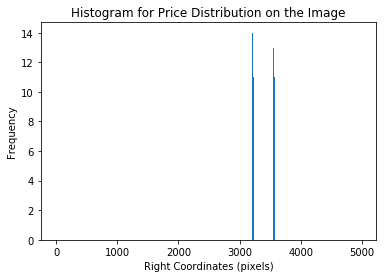

In [33]:
#Histogram for right coordinates
bins = np.arange(0,5000,20)
plt.hist(cluster()[1], bins=bins, alpha=1)
plt.xlabel('Right Coordinates (pixels)')
plt.ylabel('Frequency')
plt.title('Histogram for Price Distribution on the Image')
#plt.savefig('hist.jpg')
plt.show()